TODO:
- train
- test
- code clean
  - read yolo v3
  - data aug?
- comments
- organize notebook
  - move code out of notebook?
- increase data size ? (get more frames from the video)
- additional feature?
- poster (6/1 ?)
- presentation (6/1 9:30)
- due (6/7)

# Problem Space


The project ...

# Data

## Data Description

This data is from Caltech Pedestrian Detection Benchmark. Since this dataset contains videos in the format of mp4. We develop certain tools in order to output frames from the videos to train and validate our model for the purpose of pedestrian detection.

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import os
import random
import cv2
import matplotlib.pyplot as plt

## Data Processing

For this phase, we are trying to reformat our input images in order to fit the requirememts of tensorflow 2.0, which required by our deep learning model. We also connect the labels, the images and annotations based on this data processing phase. 

## Sample data

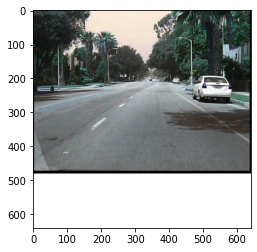

In [ ]:
image_path = '/content/drive/MyDrive/caltech-pedestrian-dataset-to-yolo-format-converter.zip (Unzipped Files)/caltech-pedestrian-dataset-to-yolo-format-converter/images/test06_V000_1125_squared.png' 
img = cv2.imread(image_path)
plt.imshow(img)

In [ ]:
img.shape

(640, 640, 3)

# Config

In [ ]:
ANCHORS_PATH              = "/content/drive/My Drive/basline_anchors.txt"
STRIDES              = [8, 16, 32]
ANCHOR_PER_SCALE     = 3
IOU_LOSS_THRESH      = 0.5

# Train options
TRAIN_ANNOT_PATH          = "/content/drive/My Drive/p_train_file.txt"
TRAIN_BATCH_SIZE          = 18
# __C.TRAIN.INPUT_SIZE            = [320, 352, 384, 416, 448, 480, 512, 544, 576, 608]
TRAIN_INPUT_SIZE          = [416]
TRAIN_DATA_AUG            = True
TRAIN_LR_INIT             = 1e-3
TRAIN_LR_END              = 1e-6
TRAIN_WARMUP_EPOCHS       = 2
TRAIN_EPOCHS              = 10 # 30

# TEST options
TEST_ANNOT_PATH           = "/content/drive/My Drive/p_test_file.txt"
TEST_BATCH_SIZE           = 2
TEST_INPUT_SIZE           = 544
TEST_DATA_AUG             = False
TEST_DECTECTED_IMAGE_PATH = "detecting"
TEST_SCORE_THRESHOLD      = 0.2
TEST_IOU_THRESHOLD        = 0.45

# Dataset class

In [ ]:
class Dataset(object):
    """implement Dataset here"""
    def __init__(self, dataset_type):
        self.annot_path  = TRAIN_ANNOT_PATH if dataset_type == 'train' else TEST_ANNOT_PATH
        self.input_sizes = TRAIN_INPUT_SIZE if dataset_type == 'train' else TEST_INPUT_SIZE
        self.batch_size  = TRAIN_BATCH_SIZE if dataset_type == 'train' else TEST_BATCH_SIZE
        self.data_aug    = TRAIN_DATA_AUG   if dataset_type == 'train' else TEST_DATA_AUG

        self.train_input_sizes = TRAIN_INPUT_SIZE
        self.strides = np.array(STRIDES)
        # self.classes = utils.read_class_names(CLASSES)
        self.classes = ['person', 'people']
        self.num_classes = len(self.classes)
        self.anchors = np.array(get_anchors("/content/drive/My Drive/basline_anchors.txt"))
        self.anchor_per_scale = ANCHOR_PER_SCALE
        self.max_bbox_per_scale = 150

        self.annotations = self.load_annotations(dataset_type)
        self.num_samples = len(self.annotations)
        self.num_batchs = int(np.ceil(self.num_samples / self.batch_size))
        self.batch_count = 0


    def load_annotations(self, dataset_type):
        with open(self.annot_path, 'r') as f:
            txt = f.readlines()
            annotations = [line.strip() for line in txt if len(line.strip().split()[1:]) != 0]
        # np.random.shuffle(annotations)
        return annotations

    def __iter__(self):
        return self

    def __next__(self):

        with tf.device('/cpu:0'):
            self.train_input_size = random.choice(self.train_input_sizes)
            self.train_output_sizes = self.train_input_size // self.strides

            batch_image = np.zeros((self.batch_size, self.train_input_size, self.train_input_size, 3), dtype=np.float32)

            batch_label_sbbox = np.zeros((self.batch_size, self.train_output_sizes[0], self.train_output_sizes[0],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)
            batch_label_mbbox = np.zeros((self.batch_size, self.train_output_sizes[1], self.train_output_sizes[1],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)
            batch_label_lbbox = np.zeros((self.batch_size, self.train_output_sizes[2], self.train_output_sizes[2],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)

            batch_sbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)
            batch_mbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)
            batch_lbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)

            num = 0
            if self.batch_count < self.num_batchs:
                while num < self.batch_size:
                    index = self.batch_count * self.batch_size + num
                    if index >= self.num_samples: index -= self.num_samples
                    annotation = self.annotations[index]
                    image, bboxes = self.parse_annotation(annotation)
                    label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes = self.preprocess_true_boxes(bboxes)
                    # image = cv2.reshape()
                    # image = cv2.resize(image, (416, 416), interpolation = cv2.INTER_AREA)
                    batch_image[num, :, :, :] = image
                    batch_label_sbbox[num, :, :, :, :] = label_sbbox
                    batch_label_mbbox[num, :, :, :, :] = label_mbbox
                    batch_label_lbbox[num, :, :, :, :] = label_lbbox
                    batch_sbboxes[num, :, :] = sbboxes
                    batch_mbboxes[num, :, :] = mbboxes
                    batch_lbboxes[num, :, :] = lbboxes
                    num += 1
                self.batch_count += 1
                batch_smaller_target = batch_label_sbbox, batch_sbboxes
                batch_medium_target  = batch_label_mbbox, batch_mbboxes
                batch_larger_target  = batch_label_lbbox, batch_lbboxes

                return batch_image, (batch_smaller_target, batch_medium_target, batch_larger_target)
            else:
                self.batch_count = 0
                # np.random.shuffle(self.annotations)
                raise StopIteration

    # def random_horizontal_flip(self, image, bboxes):

    #     if random.random() < 0.5:
    #         _, w, _ = image.shape
    #         image = image[:, ::-1, :]
    #         bboxes[:, [0,2]] = w - bboxes[:, [2,0]]

    #     return image, bboxes

    # def random_crop(self, image, bboxes):

    #     if random.random() < 0.5:
    #         h, w, _ = image.shape
    #         max_bbox = np.concatenate([np.min(bboxes[:, 0:2], axis=0), np.max(bboxes[:, 2:4], axis=0)], axis=-1)

    #         max_l_trans = max_bbox[0]
    #         max_u_trans = max_bbox[1]
    #         max_r_trans = w - max_bbox[2]
    #         max_d_trans = h - max_bbox[3]

    #         crop_xmin = max(0, int(max_bbox[0] - random.uniform(0, max_l_trans)))
    #         crop_ymin = max(0, int(max_bbox[1] - random.uniform(0, max_u_trans)))
    #         crop_xmax = max(w, int(max_bbox[2] + random.uniform(0, max_r_trans)))
    #         crop_ymax = max(h, int(max_bbox[3] + random.uniform(0, max_d_trans)))

    #         image = image[crop_ymin : crop_ymax, crop_xmin : crop_xmax]

    #         bboxes[:, [0, 2]] = bboxes[:, [0, 2]] - crop_xmin
    #         bboxes[:, [1, 3]] = bboxes[:, [1, 3]] - crop_ymin

    #     return image, bboxes

    # def random_translate(self, image, bboxes):

    #     if random.random() < 0.5:
    #         h, w, _ = image.shape
    #         max_bbox = np.concatenate([np.min(bboxes[:, 0:2], axis=0), np.max(bboxes[:, 2:4], axis=0)], axis=-1)

    #         max_l_trans = max_bbox[0]
    #         max_u_trans = max_bbox[1]
    #         max_r_trans = w - max_bbox[2]
    #         max_d_trans = h - max_bbox[3]

    #         tx = random.uniform(-(max_l_trans - 1), (max_r_trans - 1))
    #         ty = random.uniform(-(max_u_trans - 1), (max_d_trans - 1))

    #         M = np.array([[1, 0, tx], [0, 1, ty]])
    #         image = cv2.warpAffine(image, M, (w, h))

    #         bboxes[:, [0, 2]] = bboxes[:, [0, 2]] + tx
    #         bboxes[:, [1, 3]] = bboxes[:, [1, 3]] + ty

    #     return image, bboxes

    def parse_annotation(self, annotation):

        line = annotation.split()
        # print(line)
        # /content/drive/MyDrive/caltech-pedestrian-dataset-to-yolo-format-converter.zip (Unzipped Files)/caltech-pedestrian-dataset-to-yolo-format-converter/images/test06_V000_1125.png
        # image_path = '/content/drive/MyDrive/caltech-pedestrian-dataset-to-yolo-format-converter.zip (Unzipped Files)/caltech-pedestrian-dataset-to-yolo-format-converter/images/' + line[0]
        image_path = '/content/drive/MyDrive/Dataset/images/' + line[0]
        if not os.path.exists(image_path):
            raise KeyError("%s does not exist ... " %image_path)
        print(image_path)
        image = cv2.imread(image_path)
        bboxes = np.array([list(map(float, box.split(','))) for box in line[1:]])
        # print(bboxes)

        # if self.data_aug:
        #     image, bboxes = self.random_horizontal_flip(np.copy(image), np.copy(bboxes))
        #     image, bboxes = self.random_crop(np.copy(image), np.copy(bboxes))
        #     image, bboxes = self.random_translate(np.copy(image), np.copy(bboxes))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image, bboxes = image_preporcess(np.copy(image), [self.train_input_size, self.train_input_size], np.copy(bboxes))
        # print(bboxes)
        return image, bboxes

    def bbox_iou(self, boxes1, boxes2):

        boxes1 = np.array(boxes1)
        boxes2 = np.array(boxes2)

        boxes1_area = boxes1[..., 2] * boxes1[..., 3]
        boxes2_area = boxes2[..., 2] * boxes2[..., 3]

        boxes1 = np.concatenate([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                                boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
        boxes2 = np.concatenate([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                                boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

        left_up = np.maximum(boxes1[..., :2], boxes2[..., :2])
        right_down = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

        inter_section = np.maximum(right_down - left_up, 0.0)
        inter_area = inter_section[..., 0] * inter_section[..., 1]
        union_area = boxes1_area + boxes2_area - inter_area

        return inter_area / union_area

    def preprocess_true_boxes(self, bboxes):

        label = [np.zeros((self.train_output_sizes[i], self.train_output_sizes[i], self.anchor_per_scale,
                           5 + self.num_classes)) for i in range(3)] # all labels. 
        bboxes_xywh = [np.zeros((self.max_bbox_per_scale, 4)) for _ in range(3)]
        bbox_count = np.zeros((3,))

        for bbox in bboxes:
            bbox_coor = bbox[:4]
            bbox_class_ind = bbox[4] # class cat

            onehot = np.zeros(self.num_classes, dtype=np.float)
            # print(bbox)
            onehot[int(bbox_class_ind)] = 1.0
            uniform_distribution = np.full(self.num_classes, 1.0 / self.num_classes)
            deta = 0.01
            smooth_onehot = onehot * (1 - deta) + deta * uniform_distribution

            bbox_xywh = np.concatenate([(bbox_coor[2:] + bbox_coor[:2]) * 0.5, bbox_coor[2:] - bbox_coor[:2]], axis=-1)
            bbox_xywh_scaled = 1.0 * bbox_xywh[np.newaxis, :] / self.strides[:, np.newaxis]

            iou = []
            exist_positive = False
            for i in range(3):
                anchors_xywh = np.zeros((self.anchor_per_scale, 4))
                # print(anchors_xywh)
                anchors_xywh[:, 0:2] = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
                anchors_xywh[:, 2:4] = self.anchors[i]

                iou_scale = self.bbox_iou(bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh)
                iou.append(iou_scale)
                # print(iou_scale)
                iou_mask = iou_scale > 0.3

                if np.any(iou_mask):
                    xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32)

                    label[i][yind, xind, iou_mask, :] = 0
                    label[i][yind, xind, iou_mask, 0:4] = bbox_xywh
                    label[i][yind, xind, iou_mask, 4:5] = 1.0
                    label[i][yind, xind, iou_mask, 5:] = smooth_onehot

                    bbox_ind = int(bbox_count[i] % self.max_bbox_per_scale)
                    bboxes_xywh[i][bbox_ind, :4] = bbox_xywh
                    bbox_count[i] += 1

                    exist_positive = True

            if not exist_positive:
                best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
                best_detect = int(best_anchor_ind / self.anchor_per_scale)
                # print(best_anchor_ind)
                
                best_anchor = int(best_anchor_ind % self.anchor_per_scale)
                xind, yind = np.floor(bbox_xywh_scaled[best_detect, 0:2]).astype(np.int32)
                # print(best_anchor, xind, yind)

                label[best_detect][yind, xind, best_anchor, :] = 0
                label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh
                label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
                label[best_detect][yind, xind, best_anchor, 5:] = smooth_onehot

                bbox_ind = int(bbox_count[best_detect] % self.max_bbox_per_scale)
                bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh
                bbox_count[best_detect] += 1
        label_sbbox, label_mbbox, label_lbbox = label
        sbboxes, mbboxes, lbboxes = bboxes_xywh
        return label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes

    def __len__(self):
        return self.num_batchs

# Utils

In [ ]:
def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
        # print(anchors)
    anchors = np.array(anchors.split(','), dtype=np.float32)
    return anchors.reshape(3, 3, 2)

In [ ]:
def postprocess_boxes(pred_bbox, org_img_shape, input_size, score_threshold):

    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # # (1) (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # # (2) (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = org_img_shape
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # # (3) clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # # (4) discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # # (5) discard some boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    print(scores)

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

In [ ]:
def draw_bbox(image, bboxes, classes, show_label=True):
    """
    bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
    """
    classes = ['person', 'people']
    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % (classes[class_ind], score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick//2)[0]
            cv2.rectangle(image, c1, (c1[0] + t_size[0], c1[1] - t_size[1] - 3), bbox_color, -1)  # filled

            cv2.putText(image, bbox_mess, (c1[0], c1[1]-2), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)

    return image

In [ ]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
    """
    "Frozen state" and "inference mode" are two separate concepts.
    `layer.trainable = False` is to freeze the layer, so the layer will use
    stored moving `var` and `mean` in the "inference mode", and both `gama`
    and `beta` will not be updated !
    """
    def call(self, x, training=False):
        if not training:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

# Backbone

## darknet53

In [ ]:
def darknet53(input_data):

    input_data = convolutional(input_data, (3, 3,  3,  32))
    input_data = convolutional(input_data, (3, 3, 32,  64), downsample=True)

    for i in range(1):
        input_data = residual_block(input_data,  64,  32, 64)

    input_data = convolutional(input_data, (3, 3,  64, 128), downsample=True)

    for i in range(2):
        input_data = residual_block(input_data, 128,  64, 128)

    input_data = convolutional(input_data, (3, 3, 128, 256), downsample=True)

    for i in range(8):
        input_data = residual_block(input_data, 256, 128, 256)

    route_1 = input_data
    input_data = convolutional(input_data, (3, 3, 256, 512), downsample=True)

    for i in range(8):
        input_data = residual_block(input_data, 512, 256, 512)

    route_2 = input_data
    input_data = convolutional(input_data, (3, 3, 512, 1024), downsample=True)

    for i in range(4):
        input_data = residual_block(input_data, 1024, 512, 1024)

    return route_1, route_2, input_data


## convolutional

In [ ]:
def convolutional(input_layer, filters_shape, downsample=False, activate=True, bn=True):
    if downsample:
        input_layer = tf.keras.layers.ZeroPadding2D(((1, 0), (1, 0)))(input_layer)
        padding = 'valid'
        strides = 2
    else:
        strides = 1
        padding = 'same'

    conv = tf.keras.layers.Conv2D(filters=filters_shape[-1], kernel_size = filters_shape[0], strides=strides, padding=padding,
                                  use_bias=not bn, kernel_regularizer=tf.keras.regularizers.l2(0.0005),
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                  bias_initializer=tf.constant_initializer(0.))(input_layer)

    if bn: conv = BatchNormalization()(conv)
    if activate == True: conv = tf.nn.leaky_relu(conv, alpha=0.1)

    return conv

## residual

In [ ]:
def residual_block(input_layer, input_channel, filter_num1, filter_num2):
    short_cut = input_layer
    conv = convolutional(input_layer, filters_shape=(1, 1, input_channel, filter_num1))
    conv = convolutional(conv       , filters_shape=(3, 3, filter_num1,   filter_num2))

    residual_output = short_cut + conv
    return residual_output

## upsample

In [ ]:
def upsample(input_layer):
    return tf.image.resize(input_layer, (input_layer.shape[1] * 2, input_layer.shape[2] * 2), method='nearest')

# Network

## YOLOv3

In [ ]:
NUM_CLASS       = 2
ANCHORS         = get_anchors(ANCHORS_PATH)
STRIDES         = np.array(STRIDES)
IOU_LOSS_THRESH = IOU_LOSS_THRESH

def YOLOv3(input_layer):
    route_1, route_2, conv = darknet53(input_layer)

    conv = convolutional(conv, (1, 1, 1024,  512))
    conv = convolutional(conv, (3, 3,  512, 1024))
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv = convolutional(conv, (3, 3,  512, 1024))
    conv = convolutional(conv, (1, 1, 1024,  512))

    conv_lobj_branch = convolutional(conv, (3, 3, 512, 1024))
    conv_lbbox = convolutional(conv_lobj_branch, (1, 1, 1024, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1,  512,  256))
    conv = upsample(conv)

    conv = tf.concat([conv, route_2], axis=-1)

    conv = convolutional(conv, (1, 1, 768, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))

    conv_mobj_branch = convolutional(conv, (3, 3, 256, 512))
    conv_mbbox = convolutional(conv_mobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1, 256, 128))
    conv = upsample(conv)

    conv = tf.concat([conv, route_1], axis=-1)

    conv = convolutional(conv, (1, 1, 384, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))

    conv_sobj_branch = convolutional(conv, (3, 3, 128, 256))
    conv_sbbox = convolutional(conv_sobj_branch, (1, 1, 256, 3*(NUM_CLASS +5)), activate=False, bn=False)

    return [conv_sbbox, conv_mbbox, conv_lbbox]

## image preprocess

In [ ]:
def image_preporcess(image, target_size, gt_boxes=None):

    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes

## decode

In [ ]:
def decode(conv_output, i=0):
    """
    return tensor of shape [batch_size, output_size, output_size, anchor_per_scale, 5 + num_classes]
            contains (x, y, w, h, score, probability)
    """

    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]

    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))
    conv_raw_dxdy = conv_output[:, :, :, :, 0:2]
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4]
    conv_raw_conf = conv_output[:, :, :, :, 4:5]
    conv_raw_prob = conv_output[:, :, :, :, 5: ]

    y = tf.tile(tf.range(output_size, dtype=tf.int32)[:, tf.newaxis], [1, output_size])
    x = tf.tile(tf.range(output_size, dtype=tf.int32)[tf.newaxis, :], [output_size, 1])

    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)

    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)

    pred_conf = tf.sigmoid(conv_raw_conf)
    pred_prob = tf.sigmoid(conv_raw_prob)

    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

## nms

In [ ]:
def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)

    Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
          https://github.com/bharatsingh430/soft-nms
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []
    # print("bboxes")
    # print(bboxes)
    # print(888888)
    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]

        # print(666666)
        while len(cls_bboxes) > 0:
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            iou = bbox_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                # print(iou_mask)
                # print(111111)
                # print(weight)
                weight[np.array(iou_mask)] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

In [ ]:
a = np.array([True, True, False, False])
b = np.array([1, 2, 3, 4])
b[a]= 0.0
b

array([0, 0, 3, 4])

# Loss

## iou

In [ ]:
def bbox_iou(boxes1, boxes2):

    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]

    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    return 1.0 * inter_area / union_area

## giou

In [ ]:
def bbox_giou(boxes1, boxes2):

    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    boxes1 = tf.concat([tf.minimum(boxes1[..., :2], boxes1[..., 2:]),
                        tf.maximum(boxes1[..., :2], boxes1[..., 2:])], axis=-1)
    boxes2 = tf.concat([tf.minimum(boxes2[..., :2], boxes2[..., 2:]),
                        tf.maximum(boxes2[..., :2], boxes2[..., 2:])], axis=-1)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area
    iou = inter_area / union_area

    enclose_left_up = tf.minimum(boxes1[..., :2], boxes2[..., :2])
    enclose_right_down = tf.maximum(boxes1[..., 2:], boxes2[..., 2:])
    enclose = tf.maximum(enclose_right_down - enclose_left_up, 0.0)
    enclose_area = enclose[..., 0] * enclose[..., 1]
    giou = iou - 1.0 * (enclose_area - union_area) / enclose_area

    return giou

## Compute Loss

In [ ]:
def compute_loss(pred, conv, label, bboxes, i=0):

    conv_shape  = tf.shape(conv)
    batch_size  = conv_shape[0]
    output_size = conv_shape[1]
    input_size  = STRIDES[i] * output_size
    conv = tf.reshape(conv, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_conf = conv[:, :, :, :, 4:5]
    conv_raw_prob = conv[:, :, :, :, 5:]

    pred_xywh     = pred[:, :, :, :, 0:4]
    pred_conf     = pred[:, :, :, :, 4:5]

    label_xywh    = label[:, :, :, :, 0:4]
    respond_bbox  = label[:, :, :, :, 4:5]
    label_prob    = label[:, :, :, :, 5:]

    giou = tf.expand_dims(bbox_giou(pred_xywh, label_xywh), axis=-1)
    input_size = tf.cast(input_size, tf.float32)

    bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
    giou_loss = respond_bbox * bbox_loss_scale * (1- giou)

    iou = bbox_iou(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
    max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1), axis=-1)

    respond_bgd = (1.0 - respond_bbox) * tf.cast( max_iou < IOU_LOSS_THRESH, tf.float32 )

    conf_focal = tf.pow(respond_bbox - pred_conf, 2)

    conf_loss = conf_focal * (
            respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
            +
            respond_bgd * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
    )

    prob_loss = respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)

    giou_loss = tf.reduce_mean(tf.reduce_sum(giou_loss, axis=[1,2,3,4]))
    conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1,2,3,4]))
    prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1,2,3,4]))

    return giou_loss, conf_loss, prob_loss

# Training

In [ ]:
trainset = Dataset('train')
logdir = ""
steps_per_epoch = len(trainset)
# steps_per_epoch = 10
TRAIN_EPOCHS = 10
global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
warmup_steps = TRAIN_WARMUP_EPOCHS * steps_per_epoch
total_steps = TRAIN_EPOCHS * steps_per_epoch

input_tensor = tf.keras.layers.Input([416, 416, 3])
conv_tensors = YOLOv3(input_tensor)

output_tensors = []
for i, conv_tensor in enumerate(conv_tensors):
    pred_tensor = decode(conv_tensor, i)
    output_tensors.append(conv_tensor)
    output_tensors.append(pred_tensor)

model = tf.keras.Model(input_tensor, output_tensors)
optimizer = tf.keras.optimizers.Adam()
if os.path.exists(logdir): shutil.rmtree(logdir)
writer = tf.summary.create_file_writer(logdir)

def train_step(image_data, target):
    with tf.GradientTape() as tape:
        pred_result = model(image_data, training=True)
        giou_loss=conf_loss=prob_loss=0

        # optimizing process
        for i in range(3):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            loss_items = compute_loss(pred, conv, *target[i], i)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss

        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        tf.print("=> STEP %4d   lr: %.6f   giou_loss: %4.2f   conf_loss: %4.2f   "
                 "prob_loss: %4.2f   total_loss: %4.2f" %(global_steps, optimizer.lr.numpy(),
                                                          giou_loss, conf_loss,
                                                          prob_loss, total_loss))
        # update learning rate
        global_steps.assign_add(1)
        if global_steps < warmup_steps:
            lr = global_steps / warmup_steps * TRAIN_LR_INIT
        else:
            lr = TRAIN_LR_END + 0.5 * (TRAIN_LR_INIT - TRAIN_LR_END) * (
                (1 + tf.cos((global_steps - warmup_steps) / (total_steps - warmup_steps) * np.pi))
            )
        optimizer.lr.assign(lr.numpy())

        # writing summary data
        with writer.as_default():
            tf.summary.scalar("lr", optimizer.lr, step=global_steps)
            tf.summary.scalar("loss/total_loss", total_loss, step=global_steps)
            tf.summary.scalar("loss/giou_loss", giou_loss, step=global_steps)
            tf.summary.scalar("loss/conf_loss", conf_loss, step=global_steps)
            tf.summary.scalar("loss/prob_loss", prob_loss, step=global_steps)
        writer.flush()

# count = 1
for epoch in range(10):
    for image_data, target in trainset:
      # if count == 1:
        if image_data is not None:
          # print(image_data)
          train_step(image_data, target)
          # count = 0
    # model.save_weights("./yolov3")


Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Dataset/images/train05_V003_1700.png
/content/drive/MyDrive/Dataset/images/train04_V005_200.png
=> STEP   27   lr: 0.000466   giou_loss: 2.00   conf_loss: 412.03   prob_loss: 1.26   total_loss: 415.29
/content/drive/MyDrive/Dataset/images/train01_V003_100.png
/content/drive/MyDrive/Dataset/images/train04_V007_1300.png
/content/drive/MyDrive/Dataset/images/train03_V008_800.png
/content/drive/MyDrive/Dataset/images/train01_V005_1200.png
/content/drive/MyDrive/Dataset/images/train00_V012_300.png
/content/drive/MyDrive/Dataset/images/train00_V001_200.png
/content/drive/MyDrive/Dataset/images/train00_V009_400.png
/content/drive/MyDrive/Dataset/images/train00_V011_200.png
/content/drive/MyDrive/Dataset/images/train02_V010_800.png
/content/drive/MyDrive/Dataset/images/train01_V003_1700.png
/content/drive/MyDrive/Dataset/images/train01_V002_1700.png
/content/drive/MyDrive/Dataset/images/train05_V010_800.png
/content/driv

In [ ]:
model.save_weights("./yolov3")


# Testing

In [ ]:
import shutil
import colorsys

INPUT_SIZE   = 416
# NUM_CLASS    = len(read_class_names(CLASSES))
# CLASSES      = read_class_names(CLASSES)
CLASSES = ['person', 'people']
NUM_CLASS = 2

predicted_dir_path = 'predicted'
ground_truth_dir_path = 'ground-truth'
if os.path.exists(predicted_dir_path): shutil.rmtree(predicted_dir_path)
if os.path.exists(ground_truth_dir_path): shutil.rmtree(ground_truth_dir_path)
if os.path.exists(TEST_DECTECTED_IMAGE_PATH): shutil.rmtree(TEST_DECTECTED_IMAGE_PATH)

os.mkdir(predicted_dir_path)
os.mkdir(ground_truth_dir_path)
os.mkdir(TEST_DECTECTED_IMAGE_PATH)

# Build Model
input_layer  = tf.keras.layers.Input([INPUT_SIZE, INPUT_SIZE, 3])
feature_maps = YOLOv3(input_layer)

bbox_tensors = []
for i, fm in enumerate(feature_maps):
    bbox_tensor = decode(fm, i)
    bbox_tensors.append(bbox_tensor)

model = tf.keras.Model(input_layer, bbox_tensors)
model.load_weights("yolov3")

with open(TEST_ANNOT_PATH, 'r') as annotation_file:
    for num, line in enumerate(annotation_file):
        annotation = line.strip().split()
        image_path = annotation[0]
        image_name = image_path.split('/')[-1]
        # new_image_path = '/content/drive/MyDrive/caltech-pedestrian-dataset-to-yolo-format-converter.zip (Unzipped Files)/caltech-pedestrian-dataset-to-yolo-format-converter/images/' + image_path
        new_image_path = '/content/drive/MyDrive/Dataset/images/' + image_path
        print(image_path)
        image = cv2.imread(new_image_path)
        # plt.imshow(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        bbox_data_gt = np.array([list(map(float, box.split(','))) for box in annotation[1:]])

        if len(bbox_data_gt) == 0:
            bboxes_gt=[]
            classes_gt=[]
        else:
            bboxes_gt, classes_gt = bbox_data_gt[:, :4], bbox_data_gt[:, 4]
        ground_truth_path = os.path.join(ground_truth_dir_path, str(num) + '.txt')

        print('=> ground truth of %s:' % image_name)
        num_bbox_gt = len(bboxes_gt)
        with open(ground_truth_path, 'w') as f:
            for i in range(num_bbox_gt):
                class_name = CLASSES[int(classes_gt[i])]
                xmin, ymin, xmax, ymax = list(map(str, bboxes_gt[i]))
                bbox_mess = ' '.join([class_name, xmin, ymin, xmax, ymax]) + '\n'
                f.write(bbox_mess)
                print('\t' + str(bbox_mess).strip())
        print('=> predict result of %s:' % image_name)
        predict_result_path = os.path.join(predicted_dir_path, str(num) + '.txt')
        # Predict Process
        image_size = image.shape[:2]
        image_data = image_preporcess(np.copy(image), [INPUT_SIZE, INPUT_SIZE])
        image_data = image_data[np.newaxis, ...].astype(np.float32)

        pred_bbox = model.predict(image_data)
        # print(image_data)
        pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
        print(pred_bbox)
        pred_bbox = tf.concat(pred_bbox, axis=0)
        # print(pred_bbox)
        bboxes = postprocess_boxes(pred_bbox, image_size, INPUT_SIZE, TEST_SCORE_THRESHOLD)
        # print("bboxes")
        # print(bboxes)
        bboxes = nms(bboxes, TEST_IOU_THRESHOLD, method='nms')


        if TEST_DECTECTED_IMAGE_PATH is not None:
            image = draw_bbox(image, bboxes, 0)
            cv2.imwrite(TEST_DECTECTED_IMAGE_PATH+image_name, image)

        with open(predict_result_path, 'w') as f:
            for bbox in bboxes:
                coor = np.array(bbox[:4], dtype=np.int32)
                score = bbox[4]
                class_ind = int(bbox[5])
                class_name = CLASSES[class_ind]
                score = '%.4f' % score
                xmin, ymin, xmax, ymax = list(map(str, coor))
                bbox_mess = ' '.join([class_name, score, xmin, ymin, xmax, ymax]) + '\n'
                f.write(bbox_mess)
                print('\t' + str(bbox_mess).strip())



NameError: ignored

In [ ]:
model.summary()

NameError: ignored

# Results

Result: